In [39]:
import pandas as pd
from pathlib import Path
import os

In [40]:
data_path = Path(os.getcwd()).parent / "data" / "dataset_diabetes"
df = pd.read_csv(data_path / "diabetic_data.csv")

In [41]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


#### Create target attributes

In [42]:
df.loc[:, "readmit_30_days"] = (df["readmitted"] == "<30")
df.loc[:, "readmit_binary"] = (df["readmitted"] != "NO")

In [43]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmit_30_days,readmit_binary
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,NO,False,False
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,No,No,Ch,Yes,>30,False,True
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,Yes,NO,False,False
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,No,No,Ch,Yes,NO,False,False
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,No,No,Ch,Yes,NO,False,False


#### Fix missing values

In [44]:
df.loc[:, "race"] = df["race"].replace({"?": "Unknown"})
df.loc[:, "weight"] = df["weight"].replace({"?": "Unknown"})
df.loc[:, "payer_code"] = df["payer_code"].replace({"?": "Unknown"})
df.loc[:, "medical_specialty"] = df["medical_specialty"].replace({"?": "Missing"})

df.loc[:, "diag_1"] = df["diag_1"].replace({"?": "Unknown"})
df.loc[:, "diag_2"] = df["diag_2"].replace({"?": "Unknown"})
df.loc[:, "diag_3"] = df["diag_3"].replace({"?": "Unknown"})

#### Fix mapped values

In [45]:
df.loc[:, "admission_type_id"] = df["admission_type_id"]\
    .replace({1: "Emergency", 2: "Urgent", 3: "Elective"})
df.loc[:, "admission_type_id"] = df["admission_type_id"].apply(lambda x: x if x in ["Emergency", "Urgent", "Elective"] else "Other")

df.loc[:, "discharge_disposition_id"] = (df.discharge_disposition_id
                                         .apply(lambda x: "Discharged to Home" if x==1 else "Other"))

df.loc[:, "admission_source_id"] = df["admission_source_id"]\
    .replace({1: "Referral", 2: "Referral", 3: "Referral", 4: "Transfer", 5: "Transfer", 6: "Transfer", 7: "Emergency",\
              10: "Transfer", 22: "Transfer", 25: "Transfer"})
df.loc[:, "admission_source_id"] = df["admission_source_id"].apply(lambda x: x if x in ["Emergency", "Referral", "Transfer"] else "Other")

#### Fix unbalanced group medical specialty

In [46]:
df.loc[:, "medical_specialty"] = df["medical_specialty"]\
    .replace({"Cardiology-Pediatric": "Cardiology", "Gastroenterology": "InternalMedicine",\
              "Pediatrics-EmergencyMedicine": "Emergency/Trauma", "Cardiology-Pediatric": "Cardiology",\
              })
df.loc[:, "medical_specialty"] = df["medical_specialty"].apply(lambda x: "Surgery" if x.startswith("Surge") else x)

specialties = [
    "Missing",
    "InternalMedicine",
    "Emergency/Trauma",
    "Family/GeneralPractice",
    "Cardiology",
    "Surgery"
]
df.loc[:, "medical_specialty"] = df["medical_specialty"].apply(lambda x: x if x in specialties else "Other")

#### Transform diagnosis ICD-9 codes to concrete names

In [50]:
def get_diabetes_type(icd_code):
    icd_code_str = str(icd_code)
    substr_list = icd_code_str.split(".")
    #digits before and after the floating point
    if (len(substr_list) != 2):
        return None
    float_part = substr_list[-1]
    #2 digits after the floating point
    if(len(float_part) != 2):
        return None
    last_digit = float_part[len(float_part) - 1]
    match last_digit:
        case "0":
            return "Type 2"
        case "1":
            return "Type 1"
        case "2":
            return "Type 2"
        case "3":
            return "Type 1"
        case _:
            return None


df["diabetes_type"] = df.apply(lambda row: get_diabetes_type(row["diag_1"]) or get_diabetes_type(row["diag_2"]) or get_diabetes_type(row["diag_3"]), axis=1)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmit_30_days,readmit_binary,diabetes_type
0,2278392,8222157,Caucasian,Female,[0-10),Unknown,Other,Other,Referral,1,...,No,No,No,No,No,No,NO,False,False,Type 1
1,149190,55629189,Caucasian,Female,[10-20),Unknown,Emergency,Discharged to Home,Emergency,3,...,No,No,No,No,Ch,Yes,>30,False,True,Type 1
2,64410,86047875,AfricanAmerican,Female,[20-30),Unknown,Emergency,Discharged to Home,Emergency,2,...,No,No,No,No,No,Yes,NO,False,False,None
3,500364,82442376,Caucasian,Male,[30-40),Unknown,Emergency,Discharged to Home,Emergency,2,...,No,No,No,No,Ch,Yes,NO,False,False,Type 1
4,16680,42519267,Caucasian,Male,[40-50),Unknown,Emergency,Discharged to Home,Emergency,1,...,No,No,No,No,Ch,Yes,NO,False,False,None


In [53]:
df.to_csv(data_path / "diabetic_type_diabetes.csv", index=False)

In [54]:
#source: https://en.wikipedia.org/wiki/List_of_ICD-9_codes
code_to_name_regex={
        "[1][4-9][0-9]|[2][0-3][0-9]": "Neoplasms", #tumors
        "250.*": "Diabetes",
        "[3][9][0-9]|[4][0-5][0-9]": "Circulatory Issues",
        "[5][2-7][0-9]|787": "Digestive Issues",
        "[7][1-3][0-9]|781": "Musculoskeletal Issues",
        "[4][6-9][0-9]|[5][0-1][0-9]|786": "Respiratory Issues"
    }

df.loc[:, "diag_1"] = df["diag_1"].replace(regex=code_to_name_regex)
df.loc[:, "diag_2"] = df["diag_2"].replace(regex=code_to_name_regex)
df.loc[:, "diag_3"] = df["diag_3"].replace(regex=code_to_name_regex)

diagnoses = ["Neoplasms", "Diabetes", "Circulatory Issues", "Digestive Issues", "Musculoskeletal Issues", "Respiratory Issues"]
df.loc[:, "diag_1"] = df["diag_1"].apply(lambda x: x if x in diagnoses else "Other")
df.loc[:, "diag_2"] = df["diag_2"].apply(lambda x: x if x in diagnoses else "Other")
df.loc[:, "diag_3"] = df["diag_3"].apply(lambda x: x if x in diagnoses else "Other")

In [8]:
#Health insurance programs
# df.loc[:, "medicare"] = (df.payer_code == "MC")
# df.loc[:, "medicaid"] = (df.payer_code == "MD")

#### Additional binary attributes

In [55]:
df.loc[:, "had_emergency"] = (df["number_emergency"] > 0)
df.loc[:, "had_inpatient_days"] = (df["number_inpatient"] > 0)
df.loc[:, "had_outpatient_days"] = (df["number_outpatient"] > 0)

In [10]:
# cols_to_keep = ["race","gender","age","discharge_disposition_id","admission_source_id","time_in_hospital",
#     "medical_specialty","num_lab_procedures","num_procedures","num_medications","primary_diagnosis","number_diagnoses","max_glu_serum","A1Cresult","insulin","change",
#     "diabetesMed", "medicare", "medicaid", "had_emergency", "had_inpatient_days", "had_outpatient_days", "readmitted","readmit_binary","readmit_30_days"]
# final_df = df.loc[:, cols_to_keep]

### Protected groups sample sizes

#### Race

In [56]:
df["race"].value_counts()

Caucasian          76099
AfricanAmerican    19210
Unknown             2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

<Axes: >

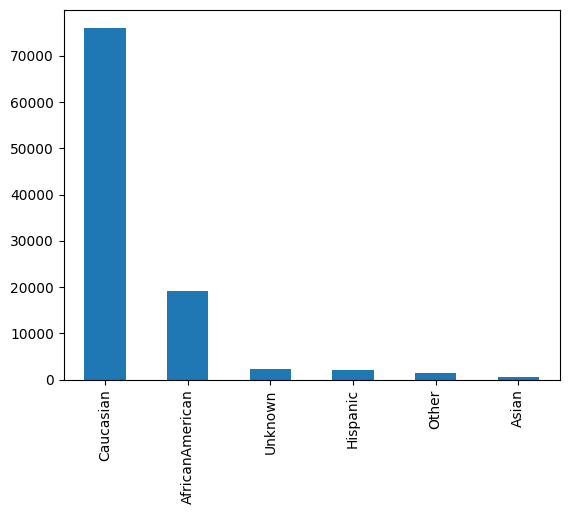

In [57]:
df["race"].value_counts().plot(kind='bar')

In [58]:
# retain the original race as race_all, and merge Asian+Hispanic+Other 
df["race_all"] = df["race"]
df["race"] = df["race"].replace({"Asian": "Other", "Hispanic": "Other"})

#### Gender

In [66]:
df["gender"].value_counts() # counts

Female    54708
Male      47055
Name: gender, dtype: int64

In [60]:
# drop gender group Unknown/Invalid
df = df.query("gender != 'Unknown/Invalid'")

#### Age

In [61]:
df["age"].value_counts()

[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

<Axes: >

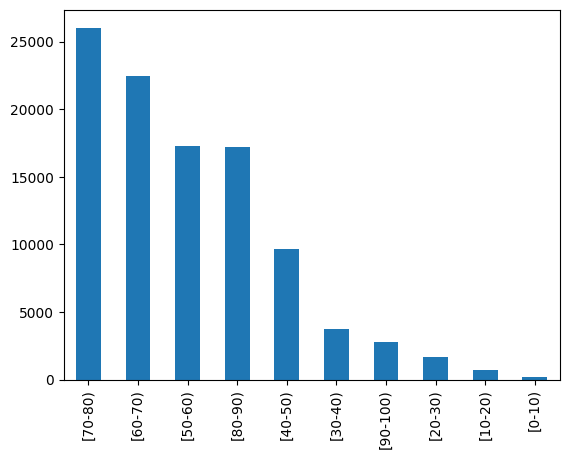

In [62]:
df["age"].value_counts().plot(kind='bar')

In [63]:
df["age_all"] = df["age"]
df.loc[:, "age"] = df["age"].replace(["[0-10)", "[10-20)", "[20-30)"], "30 years or younger")
df.loc[:, "age"] = df["age"].replace(["[30-40)", "[40-50)", "[50-60)"], "30-60 years")
df.loc[:, "age"] = df["age"].replace(["[60-70)", "[70-80)", "[80-90)", "[90-100)"], "Over 60 years")

C:\Users\Tanya\AppData\Local\Temp\ipykernel_3168\1761030426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_all"] = df["age"]
C:\Users\Tanya\AppData\Local\Temp\ipykernel_3168\1761030426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "age"] = df["age"].replace(["[0-10)", "[10-20)", "[20-30)"], "30 years or younger")
C:\Users\Tanya\AppData\Local\Temp\ipykernel_3168\1761030426.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

<Axes: >

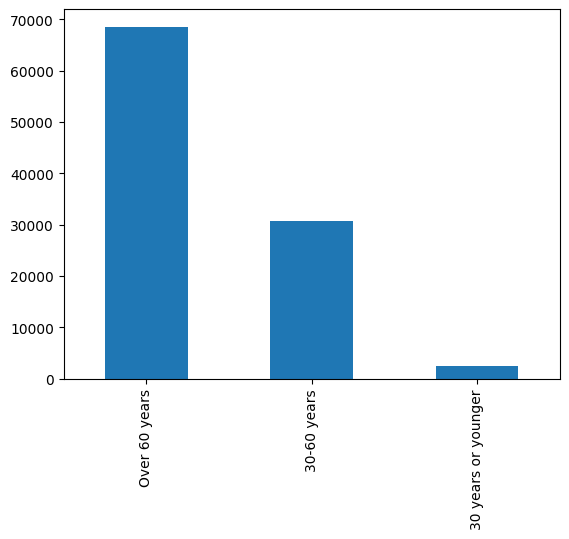

In [64]:
df["age"].value_counts().plot(kind='bar')

In [65]:
# Save DataFrame
df.to_csv(data_path / "diabetic_preprocessed.csv", index=False)